# Plot Dependency Report

This notebook plots the dependency report.


In [1]:
%reload_ext autoreload
%autoreload 2

[ utils_pickle.py:18 ] INFO: Loding bcc from /Users/szhong/Code/DepSurf/output/bcc.pkl
[utils_matplotlib.py:82 ] INFO: Saved figure to /Users/szhong/Code/DepSurf/paper/figs/report.pdf


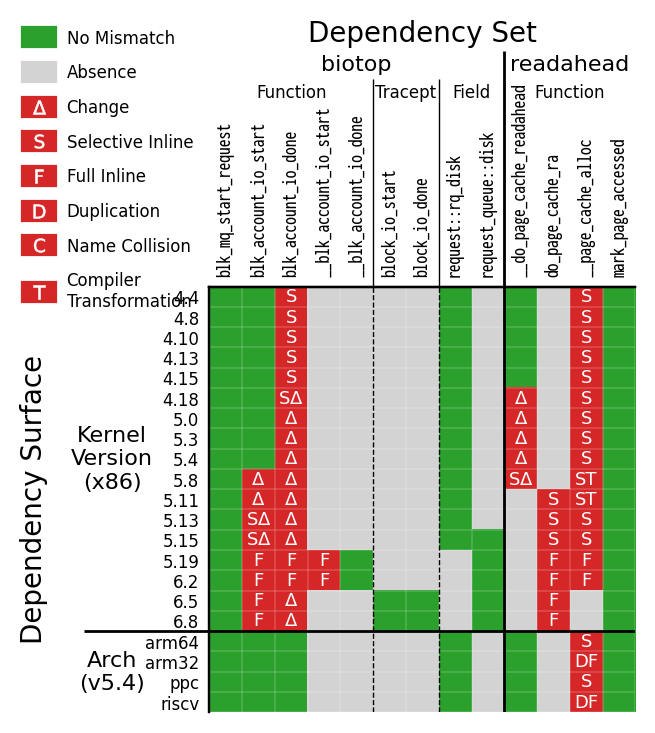

In [2]:
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

from depsurf import DepKind, ReportDict, VersionGroup, IssueEnum, IssueList
from utils import load_pkl, save_fig, FONT_MONO, ARCH_NAMES

TRANSPOSE = True


KEYS = {
    "biotop": [
        DepKind.FUNC("blk_mq_start_request"),
        DepKind.FUNC("blk_account_io_start"),
        DepKind.FUNC("blk_account_io_done"),
        DepKind.FUNC("__blk_account_io_start"),
        DepKind.FUNC("__blk_account_io_done"),
        DepKind.TRACEPOINT("block_io_start"),
        DepKind.TRACEPOINT("block_io_done"),
        DepKind.FIELD("request::rq_disk"),
        DepKind.FIELD("request_queue::disk"),
    ],
    "readahead": [
        DepKind.FUNC("__do_page_cache_readahead"),
        DepKind.FUNC("do_page_cache_ra"),
        DepKind.FUNC("__page_cache_alloc"),
        DepKind.FUNC("mark_page_accessed"),
    ],
}

GROUPS = {
    VersionGroup.REGULAR: "Kernel\nVersion\n(x86)",
    VersionGroup.ARCH: "Arch\n(v5.4)",
}

ISSUE_SYMBOLS = {
    IssueEnum.ABSENT: "",
    IssueEnum.CHANGE: r"$\Delta$",
    IssueEnum.SELECTIVE_INLINE: "S",
    IssueEnum.FULL_INLINE: "F",
    IssueEnum.DUPLICATE: "D",
    IssueEnum.COLLISSION: "C",
    IssueEnum.TRANSFORMATION: "T",
}

LEGNED = [
    ("No Mismatch", "", "tab:green"),
    ("Absence", "", "lightgray"),
    ("Change", r"$\Delta$", "tab:red"),
    ("Selective Inline", r"$\text{S}$", "tab:red"),
    ("Full Inline", r"$\text{F}$", "tab:red"),
    ("Duplication", r"$\text{D}$", "tab:red"),
    ("Name Collision", r"$\text{C}$", "tab:red"),
    ("Compiler\nTransformation", r"$\text{T}$", "tab:red"),
]

report_data: Dict[str, ReportDict] = load_pkl("bcc")
reports: ReportDict = {}
for tool_name, keys in KEYS.items():
    for key in keys:
        report = report_data[tool_name][key]
        report = {
            (group, version): v
            for (group, version), v in report.items()
            if group in GROUPS
        }
        reports[key] = report


fig, ax = plt.subplots(figsize=(2.75, 5))
ax: Axes


def get_color(issue_list: IssueList):
    if len(issue_list.issues) == 0:
        return "tab:green"
    if IssueEnum.ABSENT in issue_list.issues:
        return "lightgray"
    return "tab:red"


color = np.array(
    [
        [colors.to_rgb(get_color(issue_list)) for issue_list in report.values()]
        for report in reports.values()
    ]
)

if TRANSPOSE:
    color = color.swapaxes(0, 1)
ax.imshow(color, aspect=0.618 if TRANSPOSE else 1.2)

xlabels = []
for g in GROUPS:
    for v in g.versions:
        if g == VersionGroup.REGULAR:
            xlabels.append(v.short_version)
        elif g == VersionGroup.ARCH:
            xlabels.append(ARCH_NAMES[v.arch])

# xlabels = [l for g in GROUPS for l in g.labels]
ylabels = [d.name for d in reports.keys()]

if TRANSPOSE:
    xlabels, ylabels = ylabels, xlabels

ax.set_xticks(
    np.arange(len(xlabels)),
    labels=xlabels,
    rotation=90,
    font=FONT_MONO,
    fontsize=8,
)
ax.set_yticks(
    np.arange(len(ylabels)),
    labels=ylabels,
    fontsize=6,
)
ax.set_xticks(np.arange(len(xlabels) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(ylabels) + 1) - 0.5, minor=True)


ax.grid(which="minor", color="white", linestyle="-", linewidth=0.1)
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.spines["top"].set_visible(True)
ax.spines["bottom"].set_visible(False)
ax.tick_params(which="minor", length=0)
ax.tick_params(which="major", length=0)


def plot_secondary_ticks(
    ax: Axes,
    axis_name,
    lengths,
    labels,
    pad,
    rotation=0,
    linewidth=0.5,
    linestyle="--",
    fontsize=8,
):
    val = np.array(list(lengths))
    cum = np.cumsum(val)
    mid = cum - val / 2 - 0.5
    div = np.array([*cum][:-1]) - 0.5

    if TRANSPOSE:
        axis_name = "y" if axis_name == "x" else "x"

    if axis_name == "x":
        axis = ax.secondary_xaxis("top").xaxis
    else:
        axis = ax.secondary_yaxis("left").yaxis

    # plot labels
    axis.set_ticks(
        mid, labels, rotation=rotation, va="center", ha="center", fontsize=fontsize
    )
    axis.set_tick_params(length=0, pad=pad)

    # plot ticks
    tick_length = pad + (5 if axis_name == "x" else 10)
    axis.set_ticks(div, labels=[], minor=True)
    axis.set_tick_params(length=tick_length, width=linewidth, which="minor")

    axline = ax.axvline if axis_name == "x" else ax.axhline
    for d in div:
        axline(d, color="black", lw=linewidth, linestyle=linestyle)


plot_secondary_ticks(
    ax,
    "x",
    [len(g) for g in GROUPS],
    GROUPS.values(),
    linewidth=1,
    linestyle="-",
    pad=35,
    rotation=0 if TRANSPOSE else 0,
)

plot_secondary_ticks(
    ax,
    "y",
    [5, 2, 2, 4],
    ["Function", "Tracept", "Field", "Function"],
    fontsize=6,
    pad=70,
    rotation=0,
)

plot_secondary_ticks(
    ax,
    "y",
    [9, 4],
    ["biotop", "readahead"],
    linewidth=1,
    linestyle="-",
    pad=80,
    rotation=0 if TRANSPOSE else 90,
)


for i, report in enumerate(reports.values()):
    for j, issue_list in enumerate(report.values()):
        text = "".join([ISSUE_SYMBOLS[e] for e in issue_list.issues])
        ax.text(
            i if TRANSPOSE else j,
            j if TRANSPOSE else i,
            text,
            ha="center",
            va="center",
            color="white",
            fontsize=6.5,
        )


ax.legend(
    handles=[
        Line2D(
            [],
            [],
            linewidth=8,
            color=color,
            marker=marker,
            markerfacecolor="white",
            markeredgecolor="white",
            markeredgewidth=0.2,
            markersize=5,
        )
        for label, marker, color in LEGNED
    ],
    labels=[label for label, _, _ in LEGNED],
    loc="upper left",
    bbox_to_anchor=(-0.45, 1.64) if TRANSPOSE else (-0.8, 1.4),
    ncol=1,
    fontsize=6,
    handlelength=0.8,
    labelspacing=1,
    handletextpad=1.25,
)


xlabel = "Dependency Surface"
ylabel = "Dependency Set"

if TRANSPOSE:
    xlabel, ylabel = ylabel, xlabel

ax.set_xlabel(
    xlabel,
    fontsize=10,
    labelpad=15,
    # font="Arial",
)
ax.set_ylabel(
    ylabel,
    fontsize=10,
    labelpad=35 if TRANSPOSE else 15,
    # font="Arial",
)

save_fig(fig, "report")